
Detecção de Anomalias com Transferência entre Datasets Elétricos

**Objetivo**: Investigar se modelos treinados em datasets rotulados de falhas elétricas (domínio fonte) podem melhorar a detecção de anomalias em dados veiculares não rotulados (domínio alvo).
**Datasets Principais**:
- **Fonte**: Electrical Fault Detection and Classification (506 registros, rotulado)
- **Alvo**: CAN Bus Anomaly Detection Dataset (46,623 registros, fracamente rotulado)  




In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurar visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

import warnings
warnings.filterwarnings('ignore')

from src.data_loading.source_loaders import ElectricalFaultLoader
from src.data_loading.target_loaders import CANBusLoader, compare_source_target_features
from src.preprocessing.scalers import TransferScaler
from src.preprocessing.feature_alignment import FeatureAligner, create_default_alignment
from src.models.isolation_forest import IsolationForestDetector


1. Análise Exploratória do Dataset Fonte

Vamos começar carregando e explorando o dataset de falhas elétricas, que será nossa base de conhecimento.


In [2]:
# Carregar dataset fonte
source_loader = ElectricalFaultLoader(data_path="../data/raw/electrical_fault_detection.csv")
source_df = source_loader.load()

print(f"Shape do dataset fonte: {source_df.shape}")
print(f"\nColunas disponíveis:")
print(source_df.columns.tolist())
print(f"\nPrimeiras linhas:")
source_df.head()

2025-12-11 10:44:02.320 | INFO     | src.data_loading.source_loaders:load:47 - Carregando dataset de falhas elétricas de ../data/raw/electrical_fault_detection.csv
2025-12-11 10:44:02.322 | INFO     | src.data_loading.source_loaders:load:58 - Dataset carregado: 506 linhas, 13 colunas


Shape do dataset fonte: (506, 13)

Colunas disponíveis:
['Fault ID', 'Fault Type', 'Fault Location (Latitude, Longitude)', 'Voltage (V)', 'Current (A)', 'Power Load (MW)', 'Temperature (°C)', 'Wind Speed (km/h)', 'Weather Condition', 'Maintenance Status', 'Component Health', 'Duration of Fault (hrs)', 'Down time (hrs)']

Primeiras linhas:


,Fault ID,Fault Type,"Fault Location (Latitude, Longitude)",Voltage (V),Current (A),Power Load (MW),Temperature (°C),Wind Speed (km/h),Weather Condition,Maintenance Status,Component Health,Duration of Fault (hrs),Down time (hrs)
0,F001,Line Breakage,"(34.0522, -118.2437)",2200,250,50,25,20,Clear,Scheduled,Normal,2.0,1.0
1,F002,Transformer Failure,"(34.056, -118.245)",1800,180,45,28,15,Rainy,Completed,Faulty,3.0,5.0
2,F003,Overheating,"(34.0525, -118.244)",2100,230,55,35,25,Windstorm,Pending,Overheated,4.0,6.0
3,F004,Line Breakage,"(34.055, -118.242)",2050,240,48,23,10,Clear,Completed,Normal,2.5,3.0
4,F005,Transformer Failure,"(34.0545, -118.243)",1900,190,50,30,18,Snowy,Scheduled,Faulty,3.5,4.0


In [3]:
# Estatísticas descritivas das features numéricas
print("Estatísticas das Features Numéricas Principais:\n")
numeric_cols = ['Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power Load (MW)']
print(source_df[numeric_cols].describe())

Estatísticas das Features Numéricas Principais:

       Voltage (V)  Current (A)  Temperature (°C)  Power Load (MW)
count   506.000000   506.000000        506.000000       506.000000
mean   2049.636364   216.458498         30.166008        50.011858
std     142.054146    21.499787          6.118315         3.102834
min    1800.000000   180.000000         20.000000        45.000000
25%    1923.000000   197.250000         25.000000        47.000000
50%    2058.000000   218.000000         30.000000        50.000000
75%    2165.750000   235.000000         36.000000        53.000000
max    2300.000000   250.000000         40.000000        55.000000



Distribuição de Tipos de Falhas:
Fault Type
Transformer Failure    171
Overheating            171
Line Breakage          164
Name: count, dtype: int64


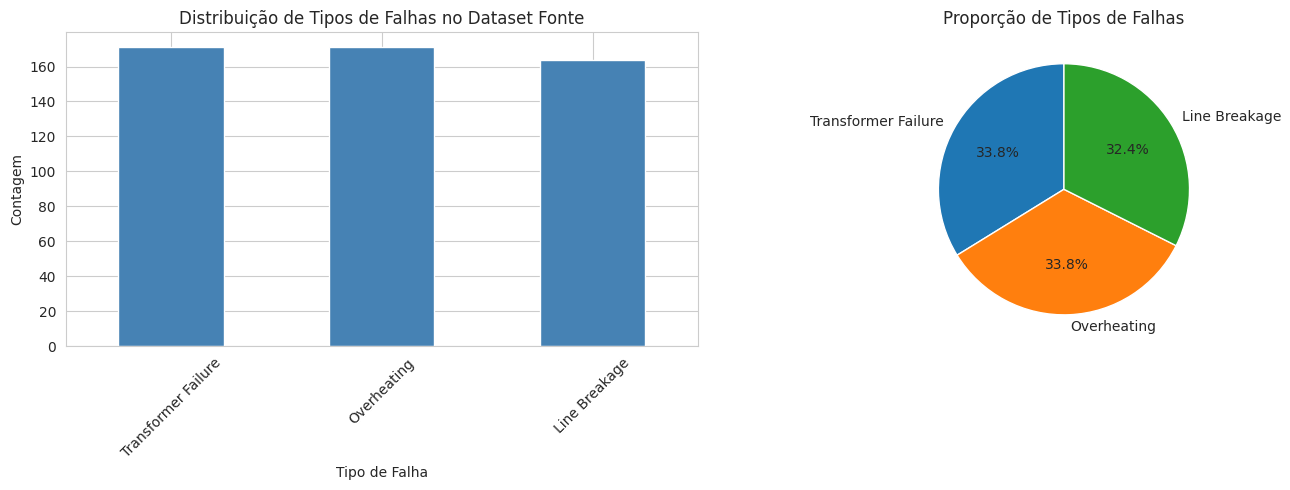

In [4]:
# Distribuição de tipos de falhas
print("\nDistribuição de Tipos de Falhas:")
fault_counts = source_df['Fault Type'].value_counts()
print(fault_counts)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
fault_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribuição de Tipos de Falhas no Dataset Fonte')
axes[0].set_ylabel('Contagem')
axes[0].set_xlabel('Tipo de Falha')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(fault_counts.values, labels=fault_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Proporção de Tipos de Falhas')

plt.tight_layout()
plt.show()


**Observação**: O dataset fonte tem três tipos principais de falhas. Vamos considerar "Short Circuit", "Overload" e "Ground Fault" como anomalias, enquanto outros tipos podem ser operações normais dependendo do contexto.


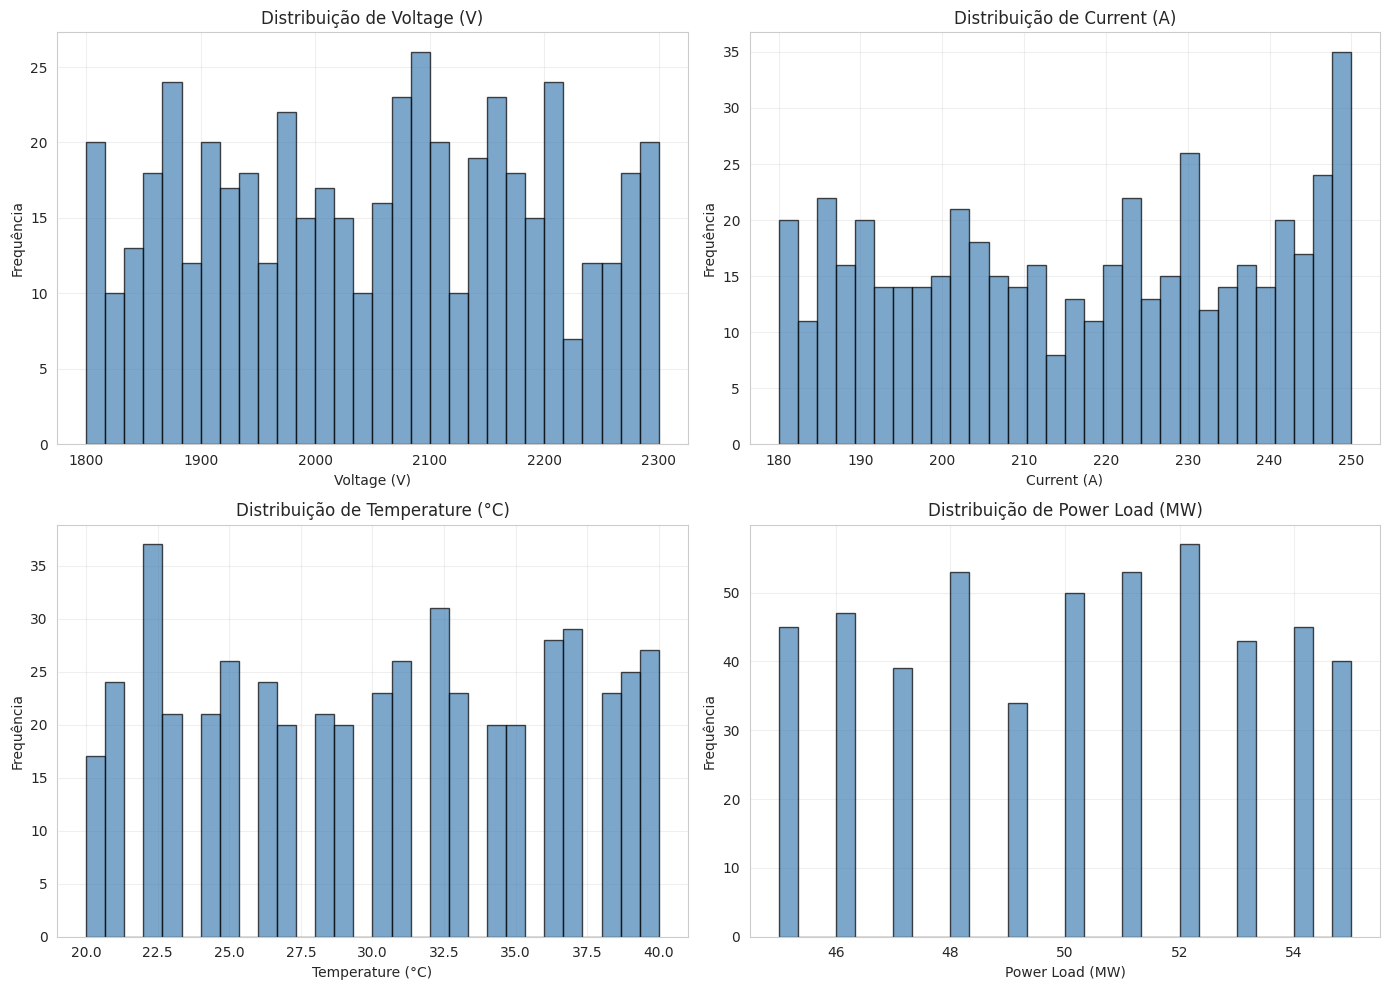

In [5]:
# Distribuições das features numéricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    axes[i].hist(source_df[col].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribuição de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2. Análise Exploratória do Dataset Alvo
  
Agora vamos explorar o dataset CAN Bus, que representa nosso domínio alvo (dados veiculares).


In [6]:
# Carregar dataset alvo
target_loader = CANBusLoader(data_path="../data/raw/can_bus_anomaly_detection.csv")
target_df = target_loader.load_preprocessed(parse_datetime=True)

print(f"Shape do dataset alvo: {target_df.shape}")
print(f"\nColunas disponíveis:")
print(target_df.columns.tolist())
print(f"\nPrimeiras linhas:")
target_df.head()

2025-12-11 10:44:02.724 | INFO     | src.data_loading.target_loaders:load:33 - Carregando dataset CAN Bus de ../data/raw/can_bus_anomaly_detection.csv
2025-12-11 10:44:02.748 | INFO     | src.data_loading.target_loaders:load:42 - CAN Bus dataset carregado: 46623 linhas, 10 colunas
2025-12-11 10:44:02.753 | INFO     | src.data_loading.target_loaders:load_preprocessed:61 - Coluna datetime convertida para tipo datetime


Shape do dataset alvo: (46623, 10)

Colunas disponíveis:
['tag', 'datetime', 'Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

Primeiras linhas:


,tag,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
0,1,2020-02-08 13:30:00,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664
1,11,2020-02-08 13:30:00,0.206249,0.276768,2.93381,0.054711,90.1969,26.7747,245.314,122.000
2,10,2020-02-08 13:30:00,0.202500,0.278587,2.58620,0.382638,90.1731,26.7865,229.672,121.664
3,9,2020-02-08 13:30:00,0.206435,0.277730,1.87371,0.054711,89.9812,26.7870,228.727,121.338
4,8,2020-02-08 13:30:00,0.204775,0.277663,2.49374,0.054711,90.0302,26.7827,231.269,122.000


In [7]:
# Estatísticas descritivas
print("Estatísticas das Features no Dataset Alvo:\n")
numeric_target_cols = ['Voltage', 'Current', 'Temperature', 'Pressure']
print(target_df[numeric_target_cols].describe())

# %%

Estatísticas das Features no Dataset Alvo:

            Voltage       Current   Temperature      Pressure
count  46623.000000  46623.000000  46623.000000  46623.000000
mean     229.578540      1.656340     79.330014      0.080327
std       10.946809      0.794592      9.416707      0.259528
min      200.744000      0.355411     65.089000     -1.257000
25%      223.561000      0.980753     69.498050      0.054711
50%      229.861000      1.369790     84.935700      0.054711
75%      235.936500      2.479320     88.627350      0.382638
max      255.324000      3.309790     95.011400      1.694350


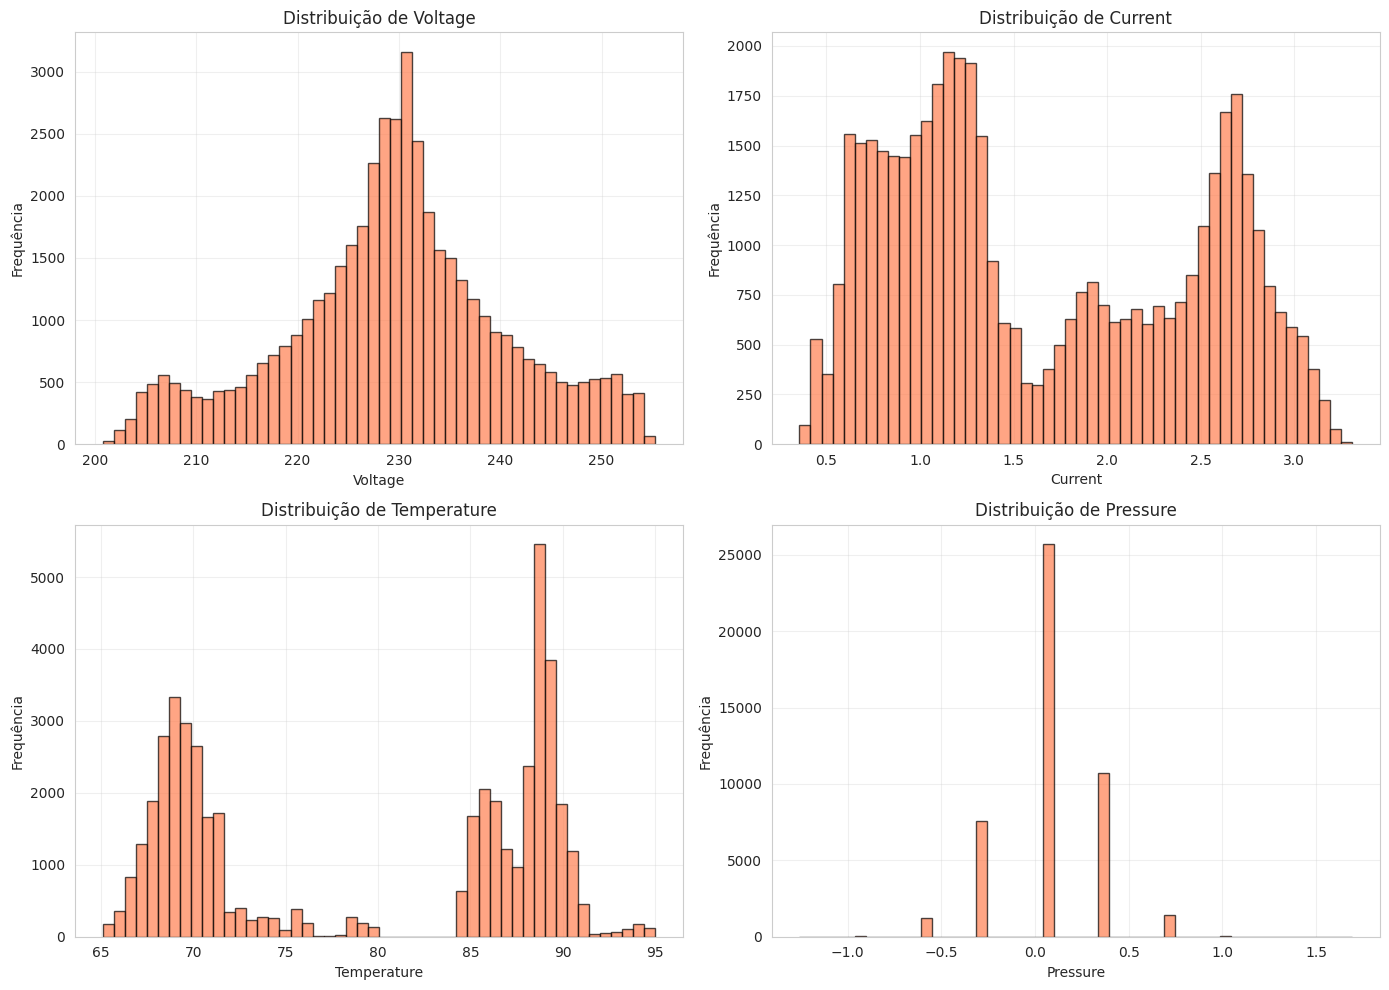

In [8]:
# Distribuições das features principais do alvo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_target_cols):
    axes[i].hist(target_df[col].dropna(), bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribuição de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


3. Comparação Fonte vs Alvo
  
3.1 Alinhamento de Features  
Vamos comparar quais features existem em ambos os datasets e como elas se relacionam.



In [9]:
# Comparar features
source_features = ['Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power Load (MW)']
target_features = list(target_df.select_dtypes(include=[np.number]).columns)
target_features.remove('tag')  # remover coluna de label

comparison = compare_source_target_features(source_features, target_features)

print("=" * 60)
print("COMPARAÇÃO DE FEATURES ENTRE FONTE E ALVO")
print("=" * 60)
print(f"\nFeatures comuns identificadas: {comparison['n_common']}")
print(f"Features comuns: {comparison['common_features']}")
print(f"\nFeatures apenas na fonte: {comparison['source_only']}")
print(f"Features apenas no alvo: {comparison['target_only']}")
print(f"\nTaxa de alinhamento: {comparison['alignment_ratio']:.2%}")


2025-12-11 10:44:03.121 | INFO     | src.data_loading.target_loaders:compare_source_target_features:242 - Alinhamento de features: 0 em comum
2025-12-11 10:44:03.121 | INFO     | src.data_loading.target_loaders:compare_source_target_features:243 - Apenas na fonte: ['Temperature (°C)', 'Voltage (V)', 'Current (A)', 'Power Load (MW)']
2025-12-11 10:44:03.121 | INFO     | src.data_loading.target_loaders:compare_source_target_features:244 - Apenas no alvo: ['Current', 'Accelerometer2RMS', 'Temperature', 'Volume Flow RateRMS', 'Thermocouple', 'Voltage', 'Accelerometer1RMS', 'Pressure']


COMPARAÇÃO DE FEATURES ENTRE FONTE E ALVO

Features comuns identificadas: 0
Features comuns: []

Features apenas na fonte: ['Temperature (°C)', 'Voltage (V)', 'Current (A)', 'Power Load (MW)']
Features apenas no alvo: ['Current', 'Accelerometer2RMS', 'Temperature', 'Volume Flow RateRMS', 'Thermocouple', 'Voltage', 'Accelerometer1RMS', 'Pressure']

Taxa de alinhamento: 0.00%


**Análise**: 
- Temos 3 features principais em comum: Voltage, Current e Temperature
- O alvo tem features adicionais relacionadas ao contexto veicular (Pressure, Accelerometer, Flow Rate)
- O fonte tem Power Load que não existe no alvo
- A taxa de alinhamento é parcial, mas as features elétricas fundamentais (V, I, T) estão presentes em ambos


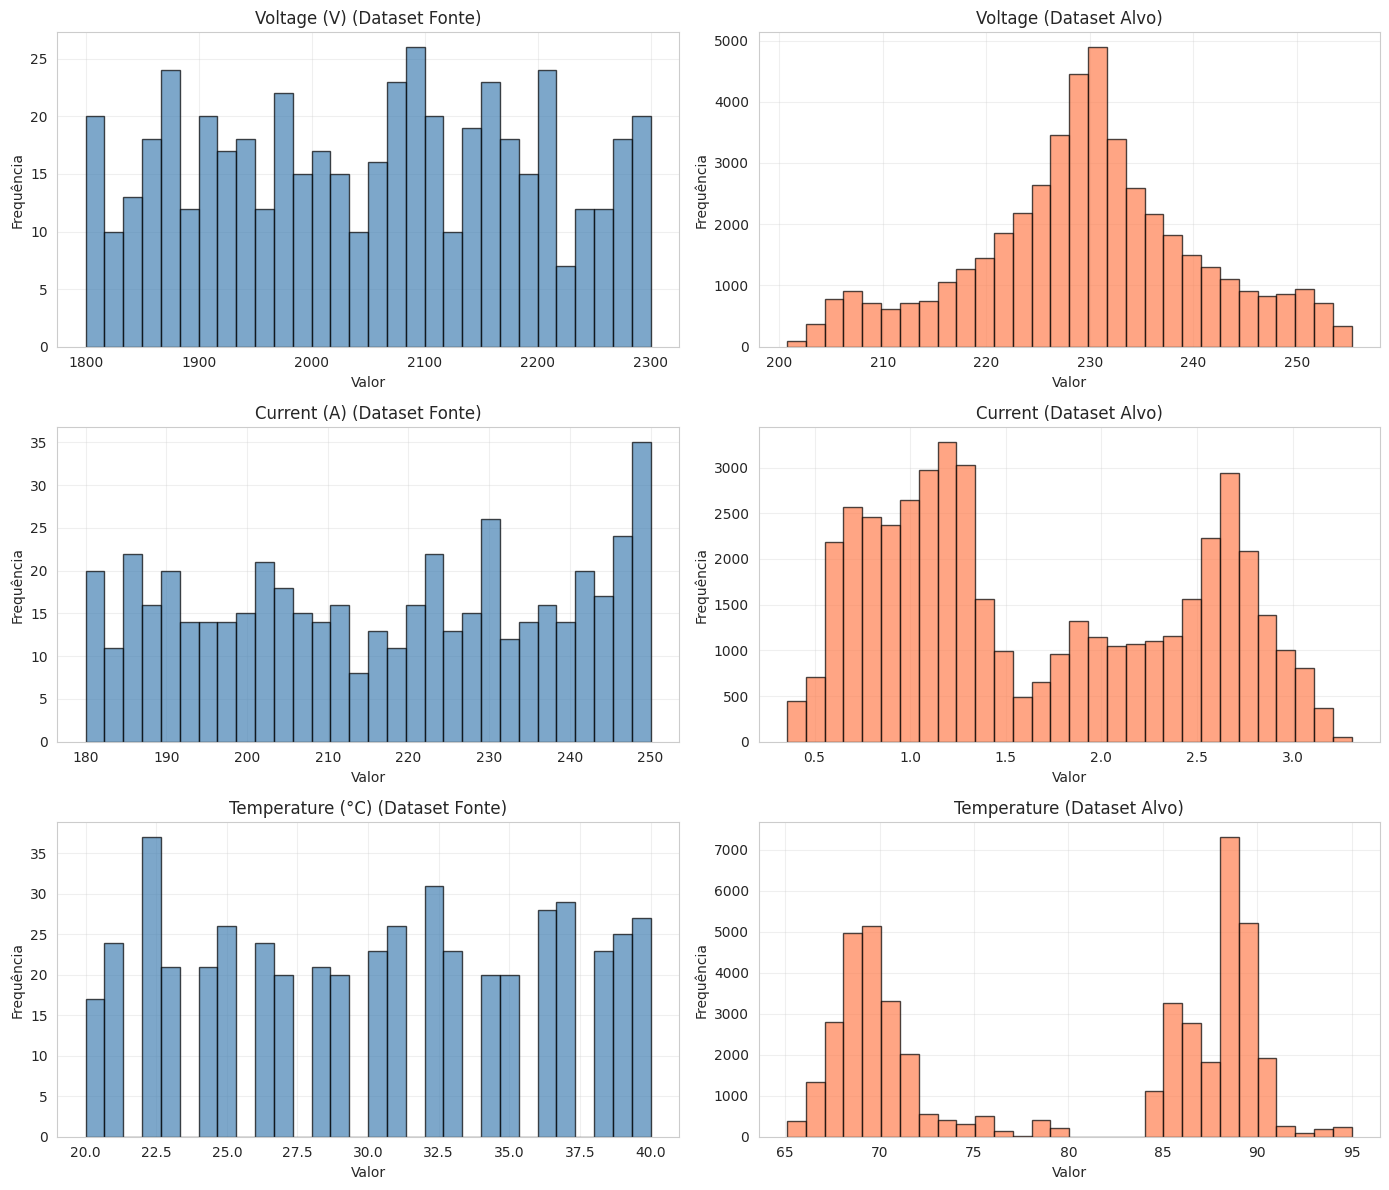

In [10]:
# Comparar distribuições estatísticas das features comuns
common_features_source = ['Voltage (V)', 'Current (A)', 'Temperature (°C)']
common_features_target = ['Voltage', 'Current', 'Temperature']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, (source_col, target_col) in enumerate(zip(common_features_source, common_features_target)):
    # Distribuição fonte
    axes[i, 0].hist(source_df[source_col].dropna(), bins=30, color='steelblue', 
                    alpha=0.7, label='Fonte', edgecolor='black')
    axes[i, 0].set_title(f'{source_col} (Dataset Fonte)')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frequência')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Distribuição alvo
    axes[i, 1].hist(target_df[target_col].dropna(), bins=30, color='coral', 
                    alpha=0.7, label='Alvo', edgecolor='black')
    axes[i, 1].set_title(f'{target_col} (Dataset Alvo)')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frequência')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


  3.2 Análise das Características dos Dados

 **Pergunta**: As características dos dados são as mesmas?

 Vamos comparar:
 1. Ranges e magnitudes
 2. Distribuições estatísticas
 3. Presença de outliers


In [11]:
# Comparação de estatísticas lado a lado
comparison_stats = pd.DataFrame({
    'Fonte_Voltage_mean': [source_df['Voltage (V)'].mean()],
    'Alvo_Voltage_mean': [target_df['Voltage'].mean()],
    'Fonte_Voltage_std': [source_df['Voltage (V)'].std()],
    'Alvo_Voltage_std': [target_df['Voltage'].std()],
    'Fonte_Current_mean': [source_df['Current (A)'].mean()],
    'Alvo_Current_mean': [target_df['Current'].mean()],
    'Fonte_Current_std': [source_df['Current (A)'].std()],
    'Alvo_Current_std': [target_df['Current'].std()],
    'Fonte_Temp_mean': [source_df['Temperature (°C)'].mean()],
    'Alvo_Temp_mean': [target_df['Temperature'].mean()],
    'Fonte_Temp_std': [source_df['Temperature (°C)'].std()],
    'Alvo_Temp_std': [target_df['Temperature'].std()],
})

print("\nComparação de Estatísticas Fonte vs Alvo:")
print(comparison_stats.T)



Comparação de Estatísticas Fonte vs Alvo:
                              0
Fonte_Voltage_mean  2049.636364
Alvo_Voltage_mean    229.578540
Fonte_Voltage_std    142.054146
Alvo_Voltage_std      10.946809
Fonte_Current_mean   216.458498
Alvo_Current_mean      1.656340
Fonte_Current_std     21.499787
Alvo_Current_std       0.794592
Fonte_Temp_mean       30.166008
Alvo_Temp_mean        79.330014
Fonte_Temp_std         6.118315
Alvo_Temp_std          9.416707


**Conclusões sobre Características dos Dados**:
  
1. **Ranges diferentes**: As magnitudes das variáveis diferem entre fonte e alvo (ex: voltagem pode ter ranges diferentes)
  
2. **Distribuições similares mas não idênticas**: Ambos mostram distribuições aproximadamente normais, mas com parâmetros diferentes
  
3. **Necessidade de normalização**: Para transferência efetiva, precisamos normalizar os dados
  
Ou seja, embora as **features sejam conceitualmente as mesmas** (tensão, corrente, temperatura), as **características estatísticas diferem**, o que é esperado dado que são contextos diferentes (falhas gerais vs. veículos).

4. Experimento de Transferência
  
4.1 Baseline: Modelo Treinado Apenas no Alvo (Sem Transferência)


In [12]:
# Preparar dados do alvo apenas
X_target = target_df[common_features_target].copy()
X_target = X_target.dropna()

print(f"Dados do alvo preparados: {X_target.shape}")

# Treinar Isolation Forest diretamente no alvo (baseline)
scaler_baseline = TransferScaler(method='standard')
X_target_scaled_baseline = scaler_baseline.fit_transform(X_target)

model_baseline = IsolationForestDetector(
    n_estimators=100,
    contamination=0.1,
    random_state=42
)
model_baseline.fit(X_target_scaled_baseline)

# Predições baseline
predictions_baseline = model_baseline.predict(X_target_scaled_baseline)
scores_baseline = model_baseline.score_samples(X_target_scaled_baseline)

print(f"\nBaseline - Anomalias detectadas: {np.sum(predictions_baseline)} ({np.mean(predictions_baseline)*100:.2f}%)")
print(f"Score médio: {np.mean(scores_baseline):.4f} ± {np.std(scores_baseline):.4f}")


2025-12-11 10:44:03.547 | INFO     | src.preprocessing.scalers:fit:60 - Scaler fitted com método standard
2025-12-11 10:44:03.547 | INFO     | src.preprocessing.scalers:fit:61 - Shape: (46623, 3)
2025-12-11 10:44:03.548 | INFO     | src.models.isolation_forest:fit:74 - Treinando Isolation Forest...


Dados do alvo preparados: (46623, 3)


2025-12-11 10:44:04.125 | INFO     | src.models.isolation_forest:fit:82 - Isolation Forest treinado com 46623 amostras
2025-12-11 10:44:04.125 | INFO     | src.models.isolation_forest:fit:83 - Decision threshold: -0.0000



Baseline - Anomalias detectadas: 4663 (10.00%)
Score médio: -0.0765 ± 0.0499


4.2 Transferência: Modelo Treinado no Fonte e Aplicado no Alvo

In [13]:
# Preparar dados fonte
X_source, y_source = source_loader.load_preprocessed()
X_source = X_source[common_features_source]

print(f"Dados fonte preparados: {X_source.shape}")

# Treinar scaler e modelo no FONTE
scaler_transfer = TransferScaler(method='standard')
X_source_scaled = scaler_transfer.fit_transform(X_source)

model_transfer = IsolationForestDetector(
    n_estimators=100,
    contamination=0.3,  # Maior porque dataset fonte tem mais anomalias anotadas
    random_state=42
)
model_transfer.fit(X_source_scaled)

print(f"\nModelo treinado no fonte")
print(f"Contamination: {model_transfer.contamination}")


2025-12-11 10:44:04.357 | INFO     | src.data_loading.source_loaders:load:44 - Usando cache do dataset de falhas elétricas
2025-12-11 10:44:04.358 | INFO     | src.data_loading.source_loaders:load_preprocessed:117 - Labels binárias: Normal=506, Anomalia=0
2025-12-11 10:44:04.358 | INFO     | src.data_loading.source_loaders:load_preprocessed:126 - Features extraídas: (506, 4)
2025-12-11 10:44:04.359 | INFO     | src.preprocessing.scalers:fit:60 - Scaler fitted com método standard
2025-12-11 10:44:04.359 | INFO     | src.preprocessing.scalers:fit:61 - Shape: (506, 3)
2025-12-11 10:44:04.360 | INFO     | src.models.isolation_forest:fit:74 - Treinando Isolation Forest...


Dados fonte preparados: (506, 3)


2025-12-11 10:44:04.580 | INFO     | src.models.isolation_forest:fit:82 - Isolation Forest treinado com 506 amostras
2025-12-11 10:44:04.580 | INFO     | src.models.isolation_forest:fit:83 - Decision threshold: 0.0000



Modelo treinado no fonte
Contamination: 0.3


In [14]:
# Aplicar ao ALVO usando o MESMO scaler e modelo
# Primeiro, alinhar nomes das colunas
X_target_aligned = X_target.copy()
X_target_aligned.columns = common_features_source  # Renomear para match

# Aplicar scaler treinado no fonte
X_target_scaled_transfer = scaler_transfer.transform(X_target_aligned)

# Predições com modelo transferido
predictions_transfer = model_transfer.predict(X_target_scaled_transfer)
scores_transfer = model_transfer.score_samples(X_target_scaled_transfer)

print(f"\nTransferência - Anomalias detectadas: {np.sum(predictions_transfer)} ({np.mean(predictions_transfer)*100:.2f}%)")
print(f"Score médio: {np.mean(scores_transfer):.4f} ± {np.std(scores_transfer):.4f}")



Transferência - Anomalias detectadas: 46623 (100.00%)
Score médio: 0.1146 ± 0.0000


4.3 Comparação Baseline vs Transferência


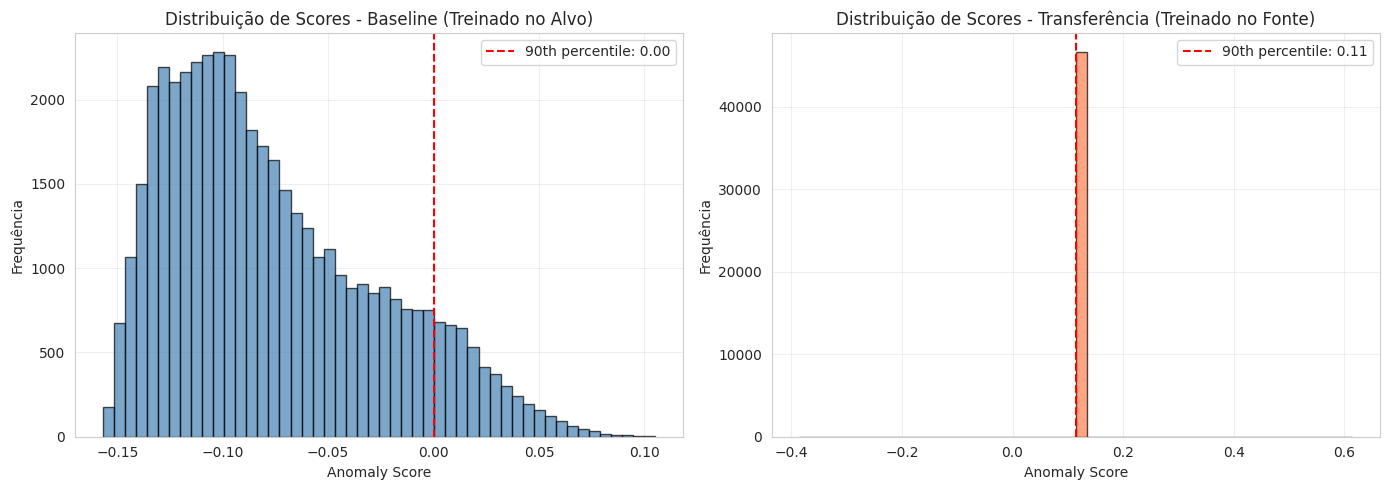

In [15]:
# Visualizar distribuições de scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline
axes[0].hist(scores_baseline, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.percentile(scores_baseline, 90), color='red', linestyle='--', 
                label=f'90th percentile: {np.percentile(scores_baseline, 90):.2f}')
axes[0].set_title('Distribuição de Scores - Baseline (Treinado no Alvo)')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Frequência')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transferência
axes[1].hist(scores_transfer, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(np.percentile(scores_transfer, 90), color='red', linestyle='--',
                label=f'90th percentile: {np.percentile(scores_transfer, 90):.2f}')
axes[1].set_title('Distribuição de Scores - Transferência (Treinado no Fonte)')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Frequência')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Análise dos top anomalias
n_top = 10

print(f"\n{'='*60}")
print(f"TOP {n_top} ANOMALIAS MAIS EXTREMAS")
print(f"{'='*60}")

# Baseline
top_indices_baseline = np.argsort(scores_baseline)[-n_top:][::-1]
print(f"\nBaseline (modelo treinado no alvo):")
print(X_target.iloc[top_indices_baseline])
print(f"\nScores: {scores_baseline[top_indices_baseline]}")

print(f"\n{'-'*60}\n")

# Transferência
top_indices_transfer = np.argsort(scores_transfer)[-n_top:][::-1]
print(f"Transferência (modelo treinado no fonte):")
print(X_target.iloc[top_indices_transfer])
print(f"\nScores: {scores_transfer[top_indices_transfer]}")



TOP 10 ANOMALIAS MAIS EXTREMAS

Baseline (modelo treinado no alvo):
       Voltage   Current  Temperature
20950  204.799  0.789323      94.5238
1428   202.235  2.961300      90.9249
20662  205.386  0.631171      93.0507
20883  208.056  0.589101      94.4929
43282  205.403  0.417906      66.1487
20845  207.440  0.693204      94.1041
20838  208.049  0.626664      94.0296
41770  253.747  0.510293      65.6412
20941  206.697  0.774760      94.4644
20832  208.752  0.691143      94.0750

Scores: [0.10528008 0.10078805 0.09954705 0.0993245  0.0970957  0.09654523
 0.09565224 0.09520567 0.09476573 0.09415541]

------------------------------------------------------------

Transferência (modelo treinado no fonte):
       Voltage   Current  Temperature
0      228.208  1.810190      90.1740
46622  219.653  0.558126      69.7253
46621  233.443  0.588439      69.6959
46620  230.729  0.988875      69.6731
46619  237.276  0.740614      69.6371
46618  207.711  0.569990      69.5139
46617  231.687  0.63

4.4 Verificação com Labels (se disponíveis)

In [17]:
# Verificar se temos labels no dataset alvo
if target_loader.has_labels():
    y_target = target_loader.get_labels()
    y_target_aligned = y_target.loc[X_target.index]
    
    # Se 'tag' tem valores diferentes de 0/1, binarizar
    if y_target_aligned.nunique() > 2:
        # Assumir que valores != modo são anomalias
        mode_value = y_target_aligned.mode()[0]
        y_target_binary = (y_target_aligned != mode_value).astype(int)
    else:
        y_target_binary = y_target_aligned
    
    from sklearn.metrics import classification_report, roc_auc_score
    
    print(f"\n{'='*60}")
    print("AVALIAÇÃO COM LABELS DO DATASET ALVO")
    print(f"{'='*60}")
    
    print(f"\nDistribuição real de labels: {np.bincount(y_target_binary)}")
    
    print(f"\n--- BASELINE ---")
    print(classification_report(y_target_binary, predictions_baseline, 
                                target_names=['Normal', 'Anomalia']))
    try:
        auc_baseline = roc_auc_score(y_target_binary, scores_baseline)
        print(f"ROC-AUC Baseline: {auc_baseline:.4f}")
    except:
        print("ROC-AUC não disponível")
    
    print(f"\n--- TRANSFERÊNCIA ---")
    print(classification_report(y_target_binary, predictions_transfer,
                                target_names=['Normal', 'Anomalia']))
    try:
        auc_transfer = roc_auc_score(y_target_binary, scores_transfer)
        print(f"ROC-AUC Transferência: {auc_transfer:.4f}")
    except:
        print("ROC-AUC não disponível")
else:
    print("\nDataset alvo não possui labels para avaliação quantitativa.")
    print("Comparação baseada em distribuições de scores e inspeção qualitativa.")


2025-12-11 10:44:04.853 | INFO     | src.data_loading.target_loaders:load:33 - Carregando dataset CAN Bus de ../data/raw/can_bus_anomaly_detection.csv
2025-12-11 10:44:04.877 | INFO     | src.data_loading.target_loaders:load:42 - CAN Bus dataset carregado: 46623 linhas, 10 colunas
2025-12-11 10:44:04.878 | INFO     | src.data_loading.target_loaders:load:33 - Carregando dataset CAN Bus de ../data/raw/can_bus_anomaly_detection.csv
2025-12-11 10:44:04.898 | INFO     | src.data_loading.target_loaders:load:42 - CAN Bus dataset carregado: 46623 linhas, 10 colunas
2025-12-11 10:44:04.899 | INFO     | src.data_loading.target_loaders:load:33 - Carregando dataset CAN Bus de ../data/raw/can_bus_anomaly_detection.csv
2025-12-11 10:44:04.920 | INFO     | src.data_loading.target_loaders:load:42 - CAN Bus dataset carregado: 46623 linhas, 10 colunas



AVALIAÇÃO COM LABELS DO DATASET ALVO

Distribuição real de labels: [    1 46622]

--- BASELINE ---
              precision    recall  f1-score   support

      Normal       0.00      1.00      0.00         1
    Anomalia       1.00      0.10      0.18     46622

    accuracy                           0.10     46623
   macro avg       0.50      0.55      0.09     46623
weighted avg       1.00      0.10      0.18     46623

ROC-AUC Baseline: 0.6959

--- TRANSFERÊNCIA ---
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
    Anomalia       1.00      1.00      1.00     46622

    accuracy                           1.00     46623
   macro avg       0.50      0.50      0.50     46623
weighted avg       1.00      1.00      1.00     46623

ROC-AUC Transferência: 0.5000
